# DATA LOADING

### URL Data

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from skimage.feature import local_binary_pattern

# Path dataset
dataset_path = "D:\\Belajar Machine Learning\\famscreen_ml\\data_mentah"

### Deteksi Wajah Menggunakan Haar Cascade

In [2]:
# Load Haar Cascade classifier untuk deteksi wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

### Fungsi Klasifikasi Kelompok Umur dan Ekstraksi Fitur

In [3]:
# Fungsi untuk mengonversi umur menjadi kategori umur
def categorize_age(age):
       if 0 <= age <= 10:
              return 0  # Anak-anak
       elif 11 <= age <= 18:
              return 1  # Remaja
       elif 19 <= age <= 59:
              return 2  # Dewasa
       elif 60 <= age <= 110:
              return 3  # Lansia
       return -1  # Label tidak valid

# Fungsi untuk ekstraksi fitur LBP
def extract_lbp_features(image, radius=1, n_points=16):
    # Hitung LBP pada gambar
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    
    # Hitung histogram dari LBP
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    
    # Normalisasi histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalisasi agar jumlah histogram = 1
    return lbp_hist

### Read Gambar dan Menyimpannya di List

In [4]:
# Inisialisasi list untuk menyimpan data
data = []

# Mendapatkan daftar file gambar dalam folder dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith((".jpg", ".png"))]
image_data_by_age = {}

# Mengelompokkan gambar berdasarkan kategori umur
for image_file in image_files:
    parts = image_file.split('_')
    age = int(parts[0])  # Mengambil usia dari nama file
    age_category = categorize_age(age)
    
    if age_category != -1:
        if age_category not in image_data_by_age:
            image_data_by_age[age_category] = []
        image_data_by_age[age_category].append(image_file)

# Proses gambar yang ada untuk ekstraksi fitur
for age_category, files in image_data_by_age.items():
    for image_file in files:
        image_path = os.path.join(dataset_path, image_file)
        
        # Baca gambar dan konversi ke grayscale
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Ubah ke grayscale untuk LBP
        
        # Deteksi wajah
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Jika wajah terdeteksi, crop wajah dan simpan
        if len(faces) > 0:
            for (x, y, w, h) in faces:
                # Crop wajah
                face_image = gray_image[y:y+h, x:x+w]
                face_image = cv2.resize(face_image, (150, 150))  # Resize wajah agar konsisten
                
                # Ekstraksi fitur LBP
                lbp_features = extract_lbp_features(face_image)
                
                # Menggabungkan label umur dan fitur LBP ke dalam list data
                data.append([age_category] + lbp_features.tolist())

### Menyimpan Data Gambar ke File CSV

In [5]:
# Konversi ke DataFrame Pandas dan simpan ke CSV
df = pd.DataFrame(data, columns=['age_category'] + [f'pixel_{i}' for i in range(len(lbp_features))])
df.to_csv("df_sampled.csv", index=False)

#### Read Data CSV

In [6]:
# Membaca data dari CSV
df = pd.read_csv("df_sampled.csv")
print(df.head())

   age_category   pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5  \
0             0  0.013378  0.023422  0.009244  0.014978  0.014667  0.048889   
1             0  0.065467  0.041911  0.023689  0.032000  0.026400  0.038089   
2             0  0.027422  0.031511  0.012889  0.021822  0.022444  0.046000   
3             0  0.076178  0.039511  0.028356  0.031556  0.028711  0.037156   
4             0  0.068756  0.044444  0.024444  0.030533  0.026711  0.039067   

    pixel_6   pixel_7   pixel_8   pixel_9  pixel_10  pixel_11  pixel_12  \
0  0.055733  0.124311  0.169067  0.207111  0.064000  0.052978  0.023378   
1  0.048444  0.078356  0.091289  0.084222  0.048756  0.041689  0.032311   
2  0.060267  0.125022  0.154133  0.138089  0.063111  0.051333  0.031156   
3  0.047600  0.073822  0.084711  0.076800  0.046533  0.037156  0.029644   
4  0.047156  0.082267  0.090889  0.085111  0.048489  0.038222  0.028711   

   pixel_13  pixel_14  pixel_15  pixel_16  pixel_17  
0  0.030711  0.01715

# DATA CLEANING

#### Cek Informasi Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age_category  453 non-null    int64  
 1   pixel_0       453 non-null    float64
 2   pixel_1       453 non-null    float64
 3   pixel_2       453 non-null    float64
 4   pixel_3       453 non-null    float64
 5   pixel_4       453 non-null    float64
 6   pixel_5       453 non-null    float64
 7   pixel_6       453 non-null    float64
 8   pixel_7       453 non-null    float64
 9   pixel_8       453 non-null    float64
 10  pixel_9       453 non-null    float64
 11  pixel_10      453 non-null    float64
 12  pixel_11      453 non-null    float64
 13  pixel_12      453 non-null    float64
 14  pixel_13      453 non-null    float64
 15  pixel_14      453 non-null    float64
 16  pixel_15      453 non-null    float64
 17  pixel_16      453 non-null    float64
 18  pixel_17      453 non-null    

#### Analisis Statistik Deskriptif

In [8]:
# Menampilkan statistik deskriptif dari dataset
df.describe(include="all")

,age_category,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17
count,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000
mean,1.607064,0.026813,0.027094,0.012290,0.018391,0.017916,0.044601,0.050701,0.117866,0.171252,0.169114,0.060872,0.047047,0.024964,0.031314,0.018730,0.012861,0.071670,0.076501
std,1.019779,0.025960,0.009949,0.007878,0.008828,0.007787,0.007270,0.010034,0.026432,0.061051,0.058418,0.009112,0.007731,0.007219,0.007363,0.009069,0.009422,0.032144,0.049024
min,0.000000,0.000089,0.003378,0.000000,0.000356,0.000400,0.028044,0.005911,0.039156,0.039333,0.042711,0.032356,0.029689,0.001733,0.017422,0.000133,0.000000,0.019556,0.004667
25%,1.000000,0.008000,0.019200,0.006400,0.011644,0.011867,0.040356,0.046356,0.100889,0.120533,0.116400,0.054800,0.042356,0.020267,0.026622,0.011600,0.005600,0.049022,0.039689
50%,2.000000,0.014400,0.025378,0.009289,0.016000,0.016400,0.043689,0.051733,0.124133,0.174178,0.184844,0.063111,0.047067,0.025289,0.030844,0.016444,0.009378,0.065511,0.057644
75%,2.000000,0.041200,0.035067,0.017689,0.026178,0.025156,0.047600,0.057111,0.138000,0.221511,0.211244,0.067511,0.051111,0.030311,0.034978,0.026578,0.018933,0.085867,0.110533
max,3.000000,0.119378,0.053867,0.037200,0.037956,0.033378,0.089600,0.074800,0.169333,0.356133,0.325867,0.079911,0.093600,0.042356,0.075956,0.040089,0.041867,0.286356,0.220800


In [9]:
# Memeriksa jumlah nilai yang hilang di setiap kolom
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

#### Cek Data Duplikat

In [10]:
# Menghapus baris duplikat
df = df.drop_duplicates()

# Memeriksa apakah ada duplikat
print(f"Jumlah data setelah menghapus duplikat: {df.shape[0]}")

Jumlah data setelah menghapus duplikat: 452


#### Memeriksa Konsistensi Kategori Usia

In [11]:
# Memeriksa distribusi kategori usia
print(df['age_category'].value_counts())

# Memastikan kategori usia hanya berisi nilai 0, 1, 2, 3
valid_age_categories = [0, 1, 2, 3]
df = df[df['age_category'].isin(valid_age_categories)]


age_category
2    174
1     98
3     94
0     86
Name: count, dtype: int64


# DATA SPLITTING

In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Pisahkan fitur (X) dan label (y)
X = df.drop(columns=['age_category'])
y = df['age_category']

# Oversample menggunakan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Lanjutkan ke train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# PELATIHAN MODEL (RANDOM FOREST)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Inisialisasi model Random Forest dengan parameter awal
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

# Melatih model
model.fit(X_train, y_train)

# Evaluasi model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi Model Random Forest:", accuracy * 100, "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Akurasi Model Random Forest: 71.42857142857143 %

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.78        42
           1       0.68      0.59      0.63        32
           2       0.62      0.69      0.66        36
           3       0.71      0.83      0.77        30

    accuracy                           0.71       140
   macro avg       0.71      0.71      0.71       140
weighted avg       0.72      0.71      0.71       140



In [14]:
import joblib

# Menyimpan model
joblib.dump(model, "famscreen_model.pkl")

['famscreen_model.pkl']

In [15]:
# Memuat model Random Forest yang telah disimpan
model = joblib.load('famscreen_model.pkl')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

d:\Python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


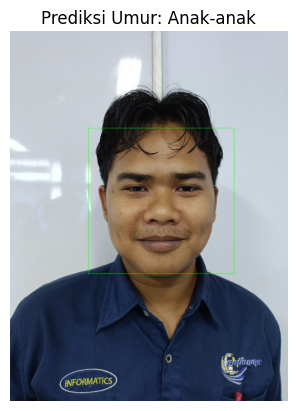

Kategori Umur Prediksi: Anak-anak


In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Fungsi untuk mengubah angka prediksi menjadi kategori usia (label teks)
def age_category_to_label(age_category):
    if age_category == 0:
        return "Anak-anak"
    elif age_category == 1:
        return "Remaja"
    elif age_category == 2:
        return "Dewasa"
    elif age_category == 3:
        return "Lansia"
    return "Tidak Valid"

# Fungsi untuk mendeteksi wajah dan ekstraksi fitur LBP dari gambar baru
def detect_and_predict(image_path, model, face_cascade, radius=1, n_points=16):
    # Membaca gambar dan konversi ke grayscale
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah dalam gambar
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Jika wajah terdeteksi
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            # Crop wajah
            face_image = gray_image[y:y+h, x:x+w]
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            face_image_resized = cv2.resize(face_image, (150, 150))

            # Ekstraksi fitur LBP
            lbp_features = extract_lbp_features(face_image_resized, radius=radius, n_points=n_points)

            # Prediksi menggunakan model Random Forest
            prediction = model.predict([lbp_features])  # Model menerima array 2D, jadi fitur LBP harus dalam list
            predicted_age_category = prediction[0]
            
            # Mengonversi angka prediksi menjadi kategori usia (label teks)
            predicted_age_label = age_category_to_label(predicted_age_category)

            # Visualisasi hasil
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f'Prediksi Umur: {predicted_age_label}')
            plt.axis('off')
            plt.show()

            return predicted_age_category, predicted_age_label
    else:
        print("Tidak ada wajah yang terdeteksi dalam gambar.")
        return None, None

# Contoh penggunaan deteksi dengan inputan gambar baru
image_path = "D:\\Belajar Machine Learning\\famscreen_ml\\images\\imageFile.jpg"  # Ganti dengan path gambar Anda
detected_age_category, predicted_age_label = detect_and_predict(image_path, model, face_cascade)

if detected_age_category is not None:
    print(f"Kategori Umur Prediksi: {predicted_age_label}")